# XGBoost and GA with GLPK
This notebook contains the implementation of a Genetic Algorithm to carry out feature selection. This hasn't produced a reasonable result however (in fact, it can't find a tree), as it appears to have selected too many features for use with BNP-OCT (35 features currently).

In [1]:
from numpy import loadtxt
import pandas as pd
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from lsopt.tree import OptimalTreeClassifier ## M-OCT propsed by Liu & Allen
from lsopt.tree import BinNodePenaltyOptimalTreeClassifier ## BNP-OCT propsed by Liu & Allen
# from lsopt.tree import OldOptimalTreeClassifier ## OCT proposed by Bertsimas & Dunn

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree 

import graphviz

%load_ext autoreload
%autoreload 2

In [2]:
data_path_fraud = './data/fraud_data_m_oct_ready.csv'
fraud_data = pd.read_csv(data_path_fraud)
fraud_data

,phy_same,phy_count,period,periodadmt,age,alife,provider_InscClaimAmtReimbursed_mean,provider_DeductibleAmtPaid_mean,provider_NoOfMonths_PartACov_mean,provider_NoOfMonths_PartBCov_mean,...,diag1_OPAnnualDeductibleAmt_mean,diag1_InscClaimAmtReimbursed_std,diag1_DeductibleAmtPaid_std,diag1_NoOfMonths_PartACov_std,diag1_NoOfMonths_PartBCov_std,diag1_IPAnnualReimbursementAmt_std,diag1_IPAnnualDeductibleAmt_std,diag1_OPAnnualReimbursementAmt_std,diag1_OPAnnualDeductibleAmt_std,PotentialFraud
0,2.960000,1.600000,1.440000,1.000000,80.240000,1.000000,4185.600000,213.600000,12.000000,12.000000,...,543.045084,3482.066310,161.353027,0.569945,0.424192,12941.552350,1205.297144,2450.076771,661.506672,Not-Fraud
1,2.439394,1.530303,3.674242,2.424242,71.371212,0.992424,4588.409091,502.166667,11.818182,11.871212,...,676.313985,4017.871066,260.257069,0.726572,0.653285,12620.604410,1226.306633,3369.338617,848.213675,Fraud
2,2.818792,1.604027,1.429530,0.000000,73.516779,0.993289,350.134228,2.080537,11.865772,11.959732,...,694.246881,1536.290845,113.086257,0.667719,0.577420,11016.516940,1111.592405,2972.377916,808.138208,Not-Fraud
3,2.731330,1.599142,1.088412,0.000000,71.783691,0.996567,241.124463,3.175966,11.907296,11.939914,...,630.805985,1234.005090,91.141252,0.657071,0.565930,10021.329570,957.701391,2727.944083,737.419878,Fraud
4,2.736111,1.527778,0.958333,0.222222,70.583333,0.986111,468.194444,45.333333,11.833333,11.833333,...,606.550334,1519.425993,103.302166,0.626542,0.520122,10565.761430,1126.358206,2486.827069,682.279276,Not-Fraud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,2.548387,1.548387,2.806452,0.000000,75.677419,1.000000,127.741935,1.612903,12.000000,12.000000,...,539.926413,1278.578369,105.316369,0.642724,0.506470,10069.067870,1048.496358,2331.087492,676.226785,Not-Fraud
1005,2.500000,1.500000,0.100000,0.000000,78.000000,1.000000,72.000000,0.000000,12.000000,12.000000,...,544.784235,589.615472,61.510304,0.690826,0.473344,10885.075840,1026.840019,2547.341333,723.822292,Not-Fraud
1006,3.000000,2.000000,0.000000,0.000000,74.000000,1.000000,50.000000,0.000000,12.000000,12.000000,...,613.157895,4778.012673,463.684066,0.600751,0.710275,13241.321690,1469.095843,3203.267596,911.406530,Not-Fraud
1007,2.333333,1.333333,2.266667,0.000000,73.933333,1.000000,296.000000,0.000000,12.000000,12.000000,...,566.953462,2506.463260,131.832995,0.726815,0.354062,11262.841610,1196.045563,2691.729344,736.415563,Not-Fraud


In [3]:
X = fraud_data.iloc[:, 0:47].to_numpy()

In [4]:
y = fraud_data["PotentialFraud"].apply(lambda val: 0 if val == "Not-Fraud" else 1).to_numpy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]    
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))  

Accuracy: 93.56%


In [6]:
thresholds = sort(model.feature_importances_)
max_acc = -1
true_thresh = -1
for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    
    predictions = [round(value) for value in y_pred]
    
    accuracy = accuracy_score(y_test, predictions)
    if accuracy >= max_acc and select_X_train.shape[1] < 20:
        max_acc = accuracy
        true_thresh = thresh
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.000, n=47, Accuracy: 93.56%
Thresh=0.005, n=41, Accuracy: 93.56%
Thresh=0.009, n=40, Accuracy: 94.06%
Thresh=0.009, n=39, Accuracy: 94.06%
Thresh=0.009, n=38, Accuracy: 94.06%
Thresh=0.010, n=37, Accuracy: 94.06%
Thresh=0.011, n=36, Accuracy: 94.55%
Thresh=0.011, n=35, Accuracy: 94.06%
Thresh=0.011, n=34, Accuracy: 94.06%
Thresh=0.012, n=33, Accuracy: 95.05%
Thresh=0.012, n=32, Accuracy: 94.06%
Thresh=0.012, n=31, Accuracy: 95.54%
Thresh=0.012, n=30, Accuracy: 94.06%
Thresh=0.013, n=29, Accuracy: 95.05%
Thresh=0.013, n=28, Accuracy: 93.56%
Thresh=0.014, n=27, Accuracy: 94.06%
Thresh=0.014, n=26, Accuracy: 94.06%
Thresh=0.014, n=25, Accuracy: 94.06%
Thresh=0.015, n=24, Accuracy: 95.54%
Thresh=0.015, n=23, Accuracy: 94.55%
Thresh=0.016, n=22, Accuracy: 93.56%
Thresh=0.017, n=21, Accuracy: 94.06%
T

In [ ]:
print(true_thresh)

0.032147862


In [18]:
from lsopt.tree import OptimalTreeClassifier ## M-OCT propsed by Liu & Allen
from lsopt.tree import BinNodePenaltyOptimalTreeClassifier ## BNP-OCT propsed by Liu & Allen
selection = SelectFromModel(model, threshold=true_thresh, prefit=True)
select_X_train = selection.transform(X_train)

# OCT parameters
max_depth = 3
min_samples_leaf = 7
alpha = 0.005
time_limit = 10 # minute
mip_gap_tol = 0.05  # optimal gap percentage
mip_focus = 'balance'
mip_polish_time = None
warm_start = False
log_file = None
fp_heur = True
backtrack = "bestb"

# Construct BNP-OCT classifier
selection_model = BinNodePenaltyOptimalTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,
                                  alpha=alpha,
                                  criterion="gini",
                                  solver="gurobi",
                                  time_limit=time_limit,
                                  verbose=True,
                                  warm_start=warm_start,
                                  log_file=log_file,
                                  solver_options={'mip_cuts': 'auto',
                                                  'mip_gap_tol': mip_gap_tol,
                                                  'mip_focus': mip_focus,
                                                  'mip_polish_time': mip_polish_time,
                                                  }
                                  )

names = []
for i in range(len(model.feature_importances_)):
    if model.feature_importances_[i] >= true_thresh:
        names.append(fraud_data.iloc[:, [i]].columns[0])
print(len(names))

7


# Explanation of below code
Alright, there's a few functions here, so lets go through them one by one.

### Split
This one is pretty straitforward, its the one that actually splits the data into a training set and a testing set

### acc_score
Returns the accuracy of each model

### plot
For plotting any results of the model, if I need to visualize it

### initialization_of_population
To initialize a random population.

### fitness_score
Returns the best parents for the next run, along with their fitness scores

### selection
Selects the best parents at the end of every run

### crossover
Picks half of the first parents, and half of the second

### mutation
Randomly flip the a feature from True to False (holding true to the principle of the genetic algorithm)

### generations
Executes all the above functions for the specified number of generations

In [20]:
def split(df,label):
    selection = SelectFromModel(model, threshold=true_thresh, prefit=True)
    X_tr = select_X_train
    X_te = X_test
    Y_tr = y_train
    Y_te = y_test
    return X_tr, X_te, Y_tr, Y_te

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier
import random

classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'AdaBoost',  'DecisionTree', 
               'KNeighbors','GradientBoosting', 'BNP-OCT']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          XGBClassifier(random_state=0),
          BinNodePenaltyOptimalTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,
                                  alpha=alpha,
                                  criterion="gini",
                                  solver="gurobi",
                                  time_limit=time_limit,
                                  verbose=True,
                                  warm_start=warm_start,
                                  log_file=log_file,
                                  solver_options={'mip_cuts': None,
                                                  'mip_gap_tol': mip_gap_tol,
                                                  'mip_focus': mip_focus,
                                                  'mip_polish_time': mip_polish_time,
                                                  }
                                  )]


def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train = select_X_train
    X_test = select_X_train
    Y_train = y_train
    Y_test = y_train
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))
    
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=bool)     
        chromosome[:int(0.3*n_feat)]=False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population


def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(select_X_train[:, chromosome],y_train)         
        predictions = logmodel.predict(select_X_train[:, chromosome])
        scores.append(accuracy_score(y_train,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = random.randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

# Explanation of cell below
The below cell essentially generates the accuracy of all the possible model classifiers that can be used (it appears that XGBoost is best, along with AdaBoost). Basically, what we're doing is running each model on the 7 features pre-selected with XGBoost, to determine which one runs in the most accurarte fashion.

In [22]:
score = acc_score(select_X_train, y_train)
score

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2433923
WLS license - registered to pranav.chaudhary@sagataltd.io
Read LP format model from file /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpmz6vog5g.pyomo.lp
Reading time = 0.27 seconds
x1: 26210 rows, 6622 columns, 438053 nonzeros
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

WLS license - registered to pranav.chaudhary@sagataltd.io
Optimize a model with 26210 rows, 6622 columns and 438053 nonzeros
Model fingerprint: 0x13e0a78c
Variable types: 6489 continuous, 133 integer (133 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [5e-03, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 2026 rows and 451 co

,Classifier,Accuracy
0,RandomForest,1.000000
1,DecisionTree,1.000000
2,GradientBoosting,0.998761
3,AdaBoost,0.944238
4,BNP-OCT,0.915737
5,KNeighbors,0.909542
6,RadialSVM,0.895911
7,Logistic,0.887237
8,LinearSVM,0.881041


## Explanation Of Below Cell

Below, I'm running the GA with BNP-OCT as its base. Basically, using the 7 features already selected by XGBoost, the idea is the GA is being used for further feature selection here. Basically, what its doing is running over multiple possible feature combinations with BNP-OCT as the classifier that its exploring. The algorithm is selecting the most accurate BNP-OCT outputs with that, and continuing to recombine, mutate etc. Currently, its taking very long, because each generation has about 2 possible solutions being explored, and those are recombined for the next set, with each possible model taking 10 minutes to train, so all combination can take upto and 1 to an hour and half to run. Also, there's a posssibility that some solutions are invalid, so if we hit upon those in the GA, it means it came across an invalid solution. Currently, I'm fixing that by removing the mutation rate, and also trying to increase the set of explored parent solution beforem moving generations (as the greater the number of parent solutions, the greater chance that the GA will ignore some in the next generation, only selecting the correct ones, but its a balancing act of not having too many parents that training takes an absurd amount of time. With XGBoost, the number of required parents was 64, which is too large a number of BNP-OCT to explore with GA).

## Next steps
If this ends up not producing anything reasonable, I could try exploring GA on hyperparameters (but that would be a lot longer on implementation, as the GA would have to be altered in a fundamental way). 

Finally, we should check with Ted, if he wants GA to be used as an alternative to MILP, as that would probably be the multi-month project of delving into _base.py and tree.py and altering those algos.

In [23]:
# Run the GA
logmodel = BinNodePenaltyOptimalTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,
                                  alpha=alpha,
                                  criterion="gini",
                                  solver="gurobi",
                                  time_limit=time_limit,
                                  verbose=True,
                                  warm_start=warm_start,
                                  log_file=log_file,
                                  solver_options={'mip_cuts': None,
                                                  'mip_gap_tol': mip_gap_tol,
                                                  'mip_focus': mip_focus,
                                                  'mip_polish_time': mip_polish_time,
                                                  }
                                  )
# X_train,X_test, Y_train, Y_test = split(X, y)
chromo_df_bc,score_bc=generations(select_X_train,y_train,size=2,n_feat=select_X_train.shape[1],n_parents=2,mutation_rate=0.00,n_gen=2,
                         X_train = select_X_train,X_test = select_X_train,Y_train = y_train,Y_test = y_train)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2433923
WLS license - registered to pranav.chaudhary@sagataltd.io
Read LP format model from file /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpvxjooct9.pyomo.lp
Reading time = 0.13 seconds
x1: 20786 rows, 6608 columns, 321527 nonzeros
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

WLS license - registered to pranav.chaudhary@sagataltd.io
Optimize a model with 20786 rows, 6608 columns and 321527 nonzeros
Model fingerprint: 0xe1215e14
Variable types: 6489 continuous, 119 integer (119 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [5e-03, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 2810 rows and 1346 c

In [25]:
# Select the features indicated by the GA
print(chromo_df_bc)
print(names)
# names = []
# select_X_train = []
# for i in range(len(chromo_df_bc[2])):
#     if chromo_df_bc[2][i] == True:
#         names.append(fraud_data.iloc[:, [i]].columns[0])
#         select_X_train.append(X_train[:, i])
# select_X_train = np.asarray(select_X_train).T
# print(len(names))
# print(select_X_train.shape)
# print(X_train.shape)
# print(Y_train.shape)
        

[array([ True,  True,  True,  True,  True, False, False]), array([ True,  True,  True,  True,  True, False, False])]
['periodadmt', 'alife', 'provider_NoOfMonths_PartACov_mean', 'provider_InscClaimAmtReimbursed_std', 'provider_NoOfMonths_PartBCov_std', 'provider_IPAnnualDeductibleAmt_std', 'provider_OPAnnualDeductibleAmt_std']


In [26]:
names_1 = []
select_X_train_1 = []
for i in range(len(chromo_df_bc[1])):
    if chromo_df_bc[1][i] == True:
        names_1.append(names[i])
        select_X_train_1.append(select_X_train[:, i])
select_X_train_1 = np.asarray(select_X_train_1).T
print(select_X_train_1.shape)
print(select_X_train.shape)

(807, 5)
(807, 7)


In [28]:
from lsopt.tree import OptimalTreeClassifier ## M-OCT propsed by Liu & Allen
from lsopt.tree import BinNodePenaltyOptimalTreeClassifier ## BNP-OCT propsed by Liu & Allen
# selection = SelectFromModel(model, threshold=true_thresh, prefit=True)
# select_X_train = selection.transform(X_train)

# OCT parameters
max_depth = 5
min_samples_leaf = 1
alpha = 0.005
time_limit = 10  # minute
mip_gap_tol = 0.05  # optimal gap percentage
mip_focus = 'balance'
mip_polish_time = None
fp_heur = True
backtrack = "bestb"

warm_start = False
log_file = None



# Construct BNP-OCT classifier
selection_model = BinNodePenaltyOptimalTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,
                                  alpha=alpha,
                                  criterion="gini",
                                  solver="gurobi",
                                  time_limit=time_limit,
                                  verbose=True,
                                  warm_start=warm_start,
                                  log_file=log_file,
                                  solver_options={'mip_cuts': None,
                                                  'mip_gap_tol': mip_gap_tol,
                                                  'mip_focus': mip_focus,
                                                  'mip_polish_time': mip_polish_time,
                                                  }
                                  )

In [29]:
selection_model.fit(select_X_train_1, y_train)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2433923
WLS license - registered to pranav.chaudhary@sagataltd.io
Read LP format model from file /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpf7uoqaql.pyomo.lp
Reading time = 1.94 seconds
x1: 104890 rows, 26480 columns, 1723863 nonzeros
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

WLS license - registered to pranav.chaudhary@sagataltd.io
Optimize a model with 104890 rows, 26480 columns and 1723863 nonzeros
Model fingerprint: 0x0ac47df0
Variable types: 25953 continuous, 527 integer (527 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [5e-03, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 1694 rows and

In [31]:
# Make prediction
# selection = SelectFromModel(model, threshold=true_thresh, prefit=True)
# select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(X=select_X_train_1)
y_pred_prob = selection_model.predict_proba(X=select_X_train_1)

# Check confusion matrix
# print("Confusion Matrix :")
# print(confusion_matrix(y_true=y_test,
#                        y_pred=y_pred))

# print(classification_report(y_true=y_test,
#                             y_pred=y_pred))

# Plot Optimal Tree
feature_names = names_1
class_names = ['Not-Fraud', 'Fraud']

dot_data = tree.export_graphviz(selection_model,
                                out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                label='all',
                                impurity=True,
                                node_ids=True,
                                filled=True,
                                rounded=True,
                                leaves_parallel=True,
                                special_characters=False)

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render(filename='optimal_tree_fraud', directory='', view=True)

'optimal_tree_fraud.png'

In [ ]:
count = 0
for element in y_pred:
    if element == 1:
        count += 1
print(count)

0


In [ ]:
print(selection_model)

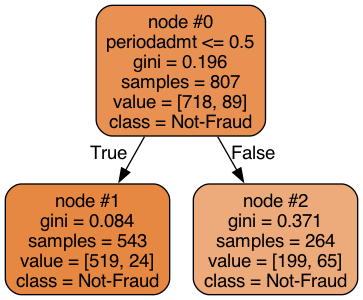

In [ ]:
Image('optimal_tree_fraud.png')

In [ ]:
import pickle
with open('model_pkl', 'wb') as file:
    pickle.dump(selection_model, file)


AttributeError: Can't pickle local object 'solve_oct_MILP_BIN.<locals>.obj_rule'